In [1]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.base import TransformerMixin
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs = 1, n_layers = 1, n_neurons_per_layer = None, leaky_slope = 0.01):
        if n_layers > 0:
            try:
                assert n_neurons_per_layer is not None
                assert len(n_neurons_per_layer) == n_layers
            except Exception as e:
                raise ValueError("provide numbers of neurons per layer defined by n_layers")
        
        super().__init__()
        self.flatten = nn.Flatten()
        if n_layers >= 1:
            stack = [ nn.Linear( n_inputs, n_neurons_per_layer[0] ) ]
            for k in range(n_layers-1):
                stack += [ nn.LeakyReLU(leaky_slope), nn.Linear(n_neurons_per_layer[k], n_neurons_per_layer[k+1]) ]
            stack += [ nn.LeakyReLU(leaky_slope), nn.Linear(n_neurons_per_layer[n_layers-1], n_outputs) ]
        else:
            stack = [ nn.Linear( n_inputs, n_outputs ) ]
        
        self.linear_relu_stack = nn.Sequential( *stack )
        self.prob_predictor = nn.Sigmoid()
        self.loss = nn.BCEWithLogitsLoss()
        for name, param in self.named_parameters():
            param.data.uniform_(-0.5,0.5)
            
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
    def predict(self, x):
        logits = self.forward(x)
        return self.prob_predictor(logits)
    
    def loss_fn(self, x, y):
        logits = self.forward(x)
        return self.loss(logits, y)
    
class DenseTransformer(TransformerMixin):
    """Transformer that turns sparse array into dense array that can go into sklearn pipeline.
    """
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.toarray()
    
class LengthsFeatureAdder(TransformerMixin):
    """Transformer that adds length and length^2 as features that can go into the Sklearn pipeline
    """
    def __init__(self, *, lengths = None):
        """
        Args:
            lengths (np.ndarray, optional): The length array of each sentence in the dataset to transform. Defaults to None but will raise an error if not provided
        """
        super().__init__()
        assert lengths is not None
        self.lengths = lengths
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        lengths = self.lengths
        assert lengths.shape[0] == X.shape[0] and lengths.shape[1] > 0
        return np.concatenate( (X, lengths), axis=1 )

In [2]:
def load_dataset(filepath):
    with open(filepath, "r") as f:
        dataset = [ json.loads(line, parse_int = str) for line in f ]
    return dataset

def get_vectorizer( texts: list[str], *, method="countvectorize", **kwargs ) -> CountVectorizer:
    """From a list of texts, output an appropriate vectorizer either using CountVectorizer or TF-IDF depending on method argument. 

     Args:
         texts (list[str]): list of strings, each item corresponding to a text.
         method (str, optional): Method to select features. Defaults to "count-vectorizer".
         **kwargs: kwarg arguments to pass to Vectorizer classes of sklearn.
    Raises:
        ValueError: If passing an non-specified method of text feature extraction

     Returns:
         pd.DataFrame: dataframe of shape (n_samples, n_features)
    """
    #We want single digits to be tokenized. This regex considers everything as a token except whitespace.
    kwargs['token_pattern'] = r'\S+' 
    if method == "countvectorize":
        vectorizer = CountVectorizer(**kwargs)
    elif method == "tfidf":
        vectorizer = TfidfVectorizer(**kwargs)
    else:
        raise ValueError(f"{method} is not a supported method.")
    #Use texts to initialize vocabulary of vectorizer
    vectorizer.fit(texts)
    return vectorizer

def sentencify(text: list) -> str:
    sentence = " ".join(text) 
    return sentence

def loss(clf, X, y):
    probs = clf.predict_log_proba(X)
    y0 = probs[:,1]
    y1 = probs[:,0]
    loss = -y*y0 - (1-y)*y1
    loss = loss.sum()/y.size
    return loss

def balanced_acc(clf, X, y):
    y_pred = clf.predict(X)
    return balanced_accuracy_score(y, y_pred, adjusted=True)

class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [3]:
with open("domain1_nn.mdl", "rb") as f:
    vectorizer_nn, scaler_nn, selector_nn, nn = pkl.load(f)

In [9]:
with open("domain1_LR.mdl", "rb") as f:
    vectorizer_lr, logres_pipeline = pkl.load(f)

In [6]:
dataset_1 = load_dataset("domain1_train_data.json")
datatexts_1 = [ sentencify(instance['text']) for instance in dataset_1 ]

In [7]:
y = np.array([1]*2500 + [0]*2500)
lengths = np.zeros((5000,2))
for i in range(5000):
    for k in range(2):
        lengths[i,k] = len(dataset_1[i]['text'])**(k+1)

X1 = vectorizer_nn.transform(datatexts_1).toarray()
X1_extended = np.hstack( (X1, lengths) )

In [10]:
#Probabilities predicted by logistic regression on domain 1
X_lr = logres_pipeline.predict_proba( X1_extended )[:,1]

In [11]:
#Probabilities predicted by logistic function on Neural Network
mps_device = torch.device("mps")
X_nn = selector_nn.transform( scaler_nn.transform(X1_extended) )
X_nn = nn.predict( torch.from_numpy(X_nn).float().to(mps_device) )
X_nn = X_nn.cpu().detach().numpy().reshape(-1)

In [12]:
final_clf = LogisticRegression(C = 10, random_state=2)

In [13]:
X_final = np.zeros( (y.size, 3) )
X_final[:,0] = X_lr
X_final[:,1] = X_nn
X_final[:,2] = X_lr * X_lr #Weigh Logistic scores by adding extra feature using its prob

In [14]:
final_clf.fit( X_final, y )

LogisticRegression(C=10, random_state=2)

/var/folders/pn/8q7lcn491b5gv4nk1m_p0ggm0000gn/T/ipykernel_15967/3862045557.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


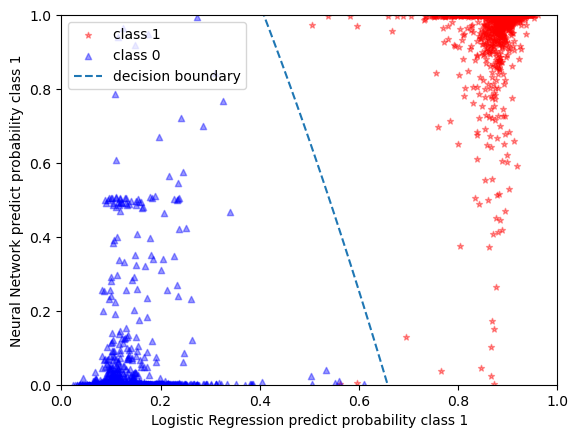

In [15]:
a1, a2, a11 = final_clf.coef_[0]
b = final_clf.intercept_
x1 = np.arange(0,1,0.01)
x2 = (-b - a1 * x1 - a11 * x1 * x1)/a2

fig, ax = plt.subplots()
ax.scatter( X_lr[:2500], X_nn[:2500], s=20, c="r", alpha=0.4, marker="*", label="class 1" )
ax.scatter( X_lr[2500:], X_nn[2500:], s=20, c="b", alpha=0.4, marker="^", label="class 0" )
ax.plot( x1, x2, "--", label="decision boundary" )
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel("Logistic Regression predict probability class 1")
ax.set_ylabel("Neural Network predict probability class 1")
ax.legend()
fig.show()

In [17]:
with open("final_domain1clf.mdl", "wb") as f:
    pkl.dump( final_clf, f )